In [11]:
#!/usr/bin/env python

#comment out if not using jupyter
%matplotlib inline 

#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

from scipy.integrate import odeint
from scipy.optimize import curve_fit


In [12]:
gene=['Gag','Env'][0]

#import data
df=pd.read_csv('data/053119_Proportions_'+gene+'.csv')
dfseed=pd.read_csv('data/HIV_DNA_Seeding_Timepoint_'+gene+'.csv') #data frame with phylogenetic proportions
dfvars=pd.read_csv('data/HIV RNA and DNA Proportions 071519 '+gene+'.csv') #data frame with variant proportions

IDs=['QG262','QF564','QD022','QC885','QB726','QB045'] #put participant IDs in order with rest of paper
czpat=['#CD5C5C','#FF8C00','#A57C00','#014421','#4682B4','#B284BE'] #color names by hex

#czpat=['indianred','darkorange','gold','forestgreen','steelblue','violet']
#IDs=set(df['ID']) #participant IDs
#vts=set(df['IIorSI']) #virus types


In [13]:
#function to get all proportions and time points
#includes detection limit put in there
def get_props(iid):
    #iid=IDs[0]

    tD_df=dfseed[dfseed['ID']==iid] #temporary data frame for DNA measurements

    #temporary data frame for all RNA measurements
    tR_df=dfvars[(dfvars['Patient']==iid) & 
           (dfvars['Nucleic_Acid']=='RNA') & 
           (dfvars['IIorSI']=='Initial') 
          ]

    tt=np.abs(np.array(tR_df['YearsSinceART'])) #years prior to ART

    Pt=[]
    for ti in tt:
        if ti in np.array(tD_df['Years_Prior_to_ART']):
            Pt.append(float(tD_df['Proportion_Each'][tD_df['Years_Prior_to_ART']==ti]))
        else:
            Pt.append(1/500)

    Pt=np.array(Pt)
    
    return tt,Pt


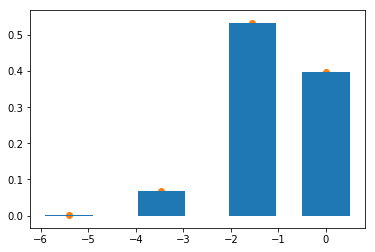

In [14]:
#example with missing data added
tt,Pt=get_props(IDs[0])
plt.bar(-tt,Pt,width=1)
plt.scatter(-tt,Pt)

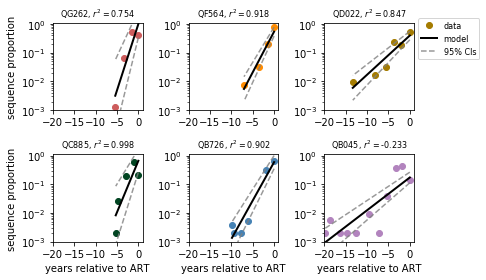

In [15]:
#fit half-lives inclusive of missing data pegged at detection limit!
#function to fit
def f(x,m,b):
    return -m*x+b

ind=0
logflg=True
#fig,axarr=plt.subplots(1,6,figsize=(12,3),sharex=True,sharey=True)
hllist=[]
for iid in IDs:

    tt,Pt=get_props(iid)
    
    x=tt; y=np.log(Pt)
        
    popt,pcov=curve_fit(f, x, y, bounds=((0, -10),(10,0)))

    rsq=1-np.sum(np.exp(f(x,popt[0],popt[1]))-np.exp(y))**2/np.sum((np.mean(np.exp(y))-np.exp(y))**2) # 1-model_sq_deviation/data_sq_deviation
    
    perr = np.sqrt(np.diag(pcov))

    tpre=np.max(x)
    xs=np.linspace(0,tpre,100) #simulation series

    upper=popt+perr*1.96/np.sqrt(len(x))
    lower=popt-perr*1.96/np.sqrt(len(x))
        
    hl=np.log(2)/popt[0]*12
    hlp=np.log(2)/upper[0]*12
    hlm=np.log(2)/lower[0]*12
    
    tdfD=df.loc[(df['ID'] == iid) & (df['Nucleic_Acid'] == 'DNA')] #temporary data frame        
    tpost=float(tdfD['YearsSinceART'].iloc[0])

    cz=czpat[ind]
    hllist.append([iid,cz,hl,hlm,hlp,tpre,tpost])
    ax=plt.subplot(2,3,ind+1)#axarr[ind]
    ax.plot(-x,np.exp(y),color=cz,marker='o',ls='')
    ax.plot(-xs,np.exp(f(xs,popt[0],popt[1])),color='black',lw=2)
    ax.plot(-xs,np.exp(f(xs,upper[0],lower[1])),color='gray',ls='--',alpha=0.8)
    ax.plot(-xs,np.exp(f(xs,lower[0],upper[1])),color='gray',ls='--',alpha=0.8)

    if logflg:
        ax.semilogy()
    tl=iid+r', $r^2=$' + str(round(rsq,3))
    ax.set_title(tl,fontsize=8)
    ax.set_ylim([1e-3,1.1])
    ax.set_xlim([-20,1])
    ax.set_xticks(range(-20,1,5))
    #ax.set_yticks(np.linspace(0,1,5))
    if ind%3==0:
        ax.set_ylabel('sequence proportion')
    if ind>2:
        ax.set_xlabel('years relative to ART')
    if ind==2:
        ax.legend(['data','model','95% CIs'],bbox_to_anchor=(1,1.1),fontsize=8)

    ind+=1
    
#axarr[0].set_ylabel('sequence proportion')

plt.tight_layout()
plt.savefig('figures/'+gene+'_HLfitALL_log'+str(logflg)+'.pdf',dpi=600)


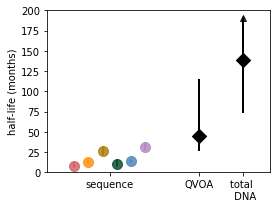

In [16]:
#compare sequence age half lives vs data
SDat=[27.4,44.2,114.5] #Siliciano half lives
GDat=[75,139,900] #golob half lives

plt.figure(figsize=(4,3))

x=np.linspace(0.6,1.4,len(hllist)) #xlocations for half live scatters

for i in range(len(x)):
    cz=hllist[i][1]
    hl=hllist[i][2]
    hlu=hllist[i][3]
    hll=hllist[i][4]
    
    if hlu<0:
        hlu=1000
    plt.scatter(x[i],hl,c=cz,alpha=0.8,s=100)
    #truncate error bars with arrow, again handmade
    if hlu>110:
        plt.plot([x[i],x[i]],[hll,190],color=cz,alpha=0.8,ls='-')
        plt.scatter(x[i],190,marker='^',c=cz,alpha=0.8) 
    else:
        plt.plot([x[i],x[i]],[hll,hlu],color=cz,alpha=1,ls='-') #handmade errorbar


plt.scatter(2,SDat[1],marker='D',s=100,c='k')
plt.plot([2, 2],[SDat[0], SDat[2]],ls='-',lw=2,color='k')

plt.scatter(2.5,GDat[1],marker='D',s=100,c='k')
plt.plot([2.5, 2.5],[GDat[0], 190],ls='-',lw=2,color='k')
plt.scatter(2.5,190,marker='^',c='k',alpha=0.8)

plt.tight_layout()
plt.xticks([1,2,2.5],['sequence','QVOA','total \n DNA'])
plt.ylabel('half-life (months)')
plt.xlim([0.3,2.8])
plt.ylim([0,200])
plt.tight_layout()
plt.savefig('figures/'+gene+'_HLcompALL.pdf',dpi=600)


In [36]:
#make a dataframe in case want to export
hl_df=pd.DataFrame(hllist,columns=['ID','color','half-life (months)','upperCI','lowerCI','time pre ART (years)','time post ART (years)'])

print(gene)
print('mean=',hl_df['half-life (months)'].mean(),' months')
print('median=',hl_df['half-life (months)'].median(),' months')
    

Gag
mean= 17.04324313379866  months
median= 13.126564718157008  months


In [ ]:
#compare sequence half life to time pre ART
plt.figure(figsize=(4,3))

for i in range(len(hllist)):
    plt.scatter(hllist[i][5],hllist[i][6],s=hllist[i][2]**2,color=hllist[i][1],alpha=0.8)
                
plt.ylabel('ART duration (years)')
plt.xlabel('time pre ART (years)')
plt.title(r'circle size $\propto (t_{1/2})^2$',fontsize=8)
plt.tight_layout()
plt.savefig('figures/'+gene+'_HLcheck3DALL.pdf',dpi=600)
